In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
import matplotlib.pyplot as plt

import pickle
import yaml
import numpy as np
from RetaredHarmonicDynamics import animate_particle
from matplotlib import animation
from scipy.stats import moment
from scipy.special import factorial, lambertw, erf
from pathlib import Path

tensor = torch.tensor

from my_functions import get_pos, get_mean_std, FokkerPlankCalculator, time_delayed_harmonic, damped_harmonic_oszillator
from my_functions import get_approx_freq,get_zero, get_pos_with_border

pic_path = Path('Graphic_Results/')

In [3]:
save_run = False

In [4]:
forces = {
    "no": lambda i: 0,
    "const": lambda i:2e-3,
    "ramp": lambda i: 0.005*i/(max_t),
    "oszi": lambda i: 0.005*np.cos(i * 10)
}

# No Froce

In [5]:
with open('std_parameter_setting.yaml') as f:
    std_parameter_setting = yaml.load(f , Loader=yaml.SafeLoader)

# num_particle = 20000
# max_t = 2
# dt = 1e-3

# tau = 0.1
# k = 12
# border = 1.5e-3

num_particle = std_parameter_setting['num_particle']
max_t = std_parameter_setting['max_t']
dt = std_parameter_setting['dt']

tau = std_parameter_setting['tau']
k = std_parameter_setting['k']
border = std_parameter_setting['border']

D = float(std_parameter_setting['D'])

In [6]:
def plot_simulated_rate(
    k,
    tau,
    border,
    dt = 1e-3,
    num_particle = 20000,
    max_t = 2.5,
    F=lambda i:0,
    safe_name=None):
    pos = get_pos_with_border(border = border,
                              num_particle=num_particle,
                              max_t = max_t+tau,
                              dt = dt,
                              tau=tau,
                              k=k,
                              F=F)[int(tau/dt):]
    time = np.linspace(0,max_t,len(pos))
    particles = (~pos.isnan()).sum(1)

    fig, axs = plt.subplots(1,2, figsize=(9,4))
    axs[0].plot(time,particles)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Number of particles')

    p_diff_raw = particles.diff(dim=0)*1.
    p_diff = p_diff_raw.clone()

    mean_bin = 50
    p_diff = p_diff.squeeze()
    p_diff = torch.stack([p_diff.repeat(mean_bin,1).diag(i).mean() 
                          for i in range(len(p_diff))])
    p_diff = p_diff.unsqueeze(1)
    
    
    # for i in range(500):
    #     p_diff[1:-1] = (p_diff[2:]+p_diff[1:-1]+p_diff[:-2])/3
    #     p_diff[0] = (p_diff[0]+p_diff[1])/2
    #     p_diff[-1] = (p_diff[-1]+p_diff[-2])/2
    axs[1].plot(time[:-1],p_diff_raw, alpha=0.2, label='raw')
    axs[1].plot(time[:-1],p_diff, label='smoothed')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change of number of particles')
    axs[1].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_particles.pdf')
    plt.show()
    
    rate_raw = -p_diff_raw/particles[1:]/dt
    rate = -p_diff/particles[1:]/dt
    plt.plot(time[:-1],rate_raw, alpha=0.2)
    plt.plot(time[:-1],rate)
    average = 500
    print(rate_raw[-average:].mean(), 1/np.sqrt(average)*rate_raw[-average:].std())
    plt.xlabel("Time")
    plt.ylabel(r"Rate $\kappa$")
    if safe_name:
        plt.savefig(pic_path/f'{safe_name}_rate.pdf')
    plt.show()
    return pos, particles,rate, np.linspace(0,max_t,len(rate))

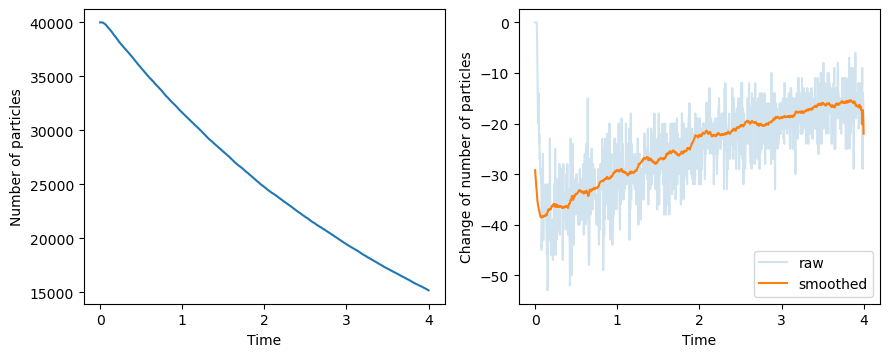

tensor(0.2448) tensor(0.0026)


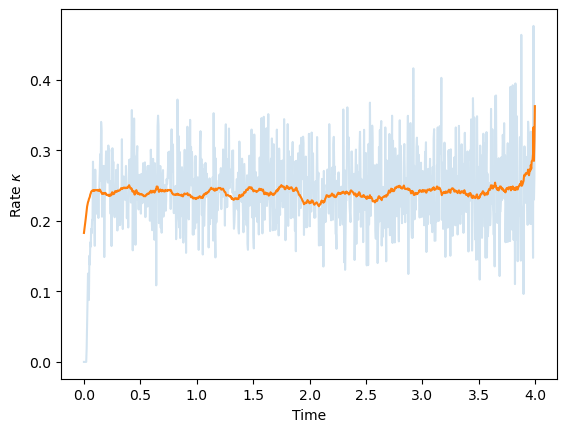

In [7]:
pos, particles_no_force, rate_no_force, time_no_force = plot_simulated_rate(
    tau=tau,
    k=k,
    num_particle=num_particle,
    dt=dt,
    border=border,
    max_t=max_t,
    F=forces['no'],
    safe_name='no_force')

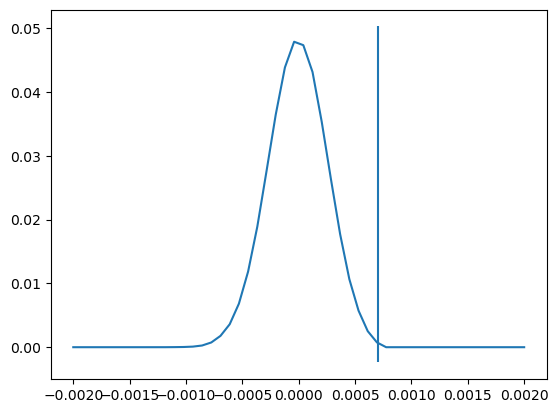

In [8]:
average = 50
xlim = (-2e-3,2e-3)
values = pos[-average:,:,0].flatten()
hist = values[~values.isnan()].float().histc(bins=50, min=xlim[0], max=xlim[1], )/num_particle/average

plt.plot(np.linspace(*xlim,50),hist)
plt.vlines([border],*plt.ylim())

# Constant Force

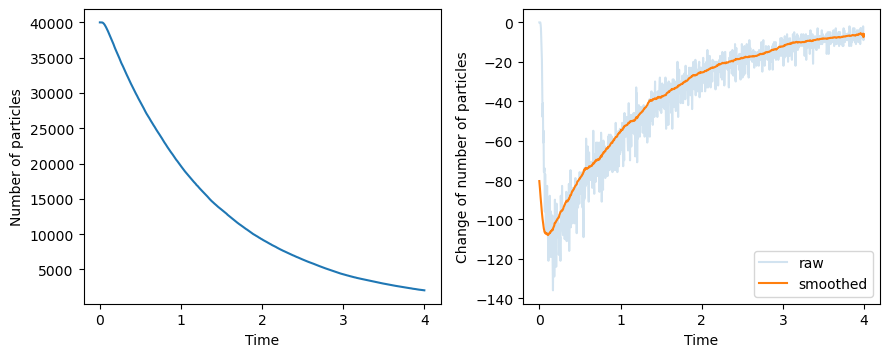

tensor(0.7601) tensor(0.0098)


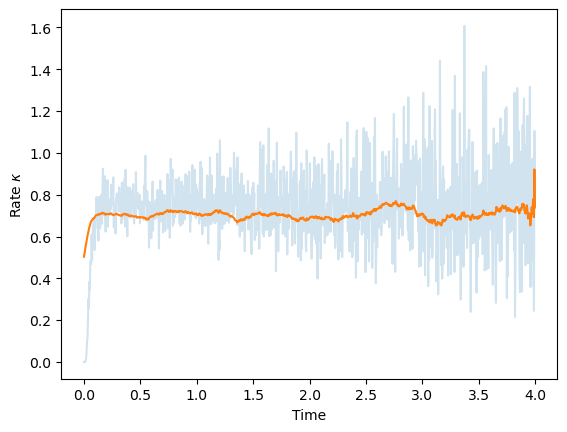

In [9]:
pos, particles_const,rate_const, time_const = plot_simulated_rate(
    k=k,
    tau=tau,
    num_particle=num_particle,
    border=border,
    F= forces['const'],
    max_t=max_t,
    dt=dt,
    safe_name='const_force')
    
#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Force Ramp

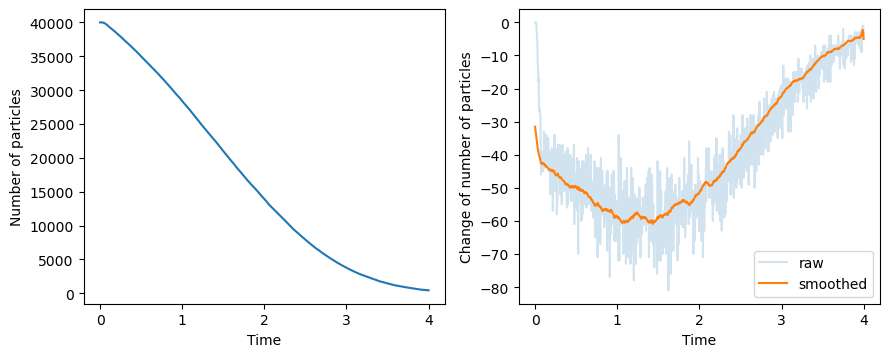

tensor(1.7492) tensor(0.0329)


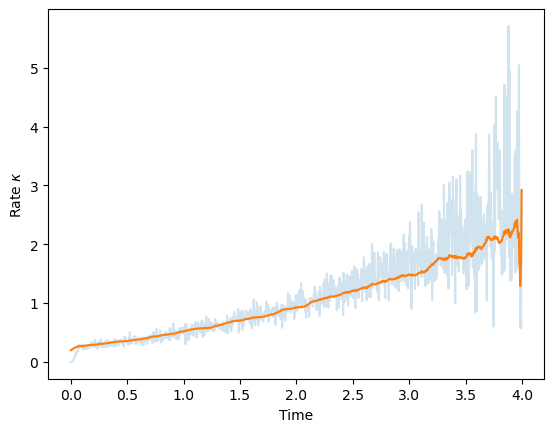

In [10]:
pos,particles_ramp, rate_ramp, time_ramp = plot_simulated_rate(
    k=k,
    tau=tau,
    num_particle=num_particle,
    border=border,
    F= forces['ramp'],
    max_t = max_t,
    dt = dt,
    safe_name='force_ramp')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Oszillatory Force

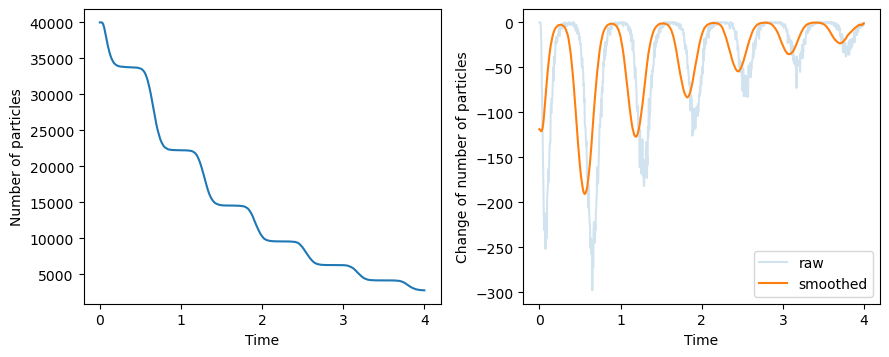

tensor(0.6638) tensor(0.0355)


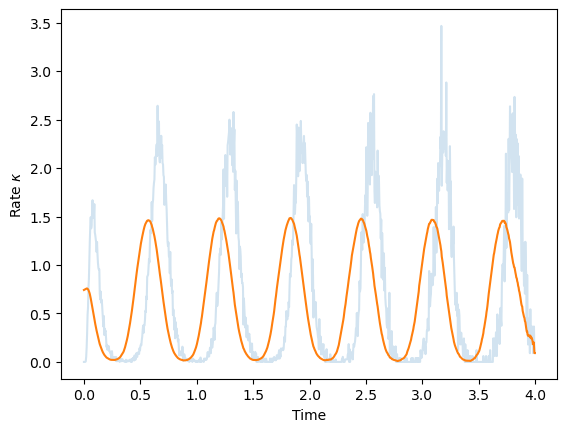

In [11]:
pos, particles_oszi,rate_oszi, time_oszi = plot_simulated_rate(
    k=k,
    tau=tau,
    num_particle=num_particle,
    border=border,
    F= forces['oszi'],
    max_t = max_t,
    dt=dt,
    safe_name='oszi_force')

#if torch.__version__ != '1.9.1':
#    plt.plot(pos.nanmean(dim=1))

# Bullerjan

In [12]:
my_fpc = FokkerPlankCalculator()
s = np.sqrt(2*D)
b= border

# prot = 'oszi'

sim_res = {
    "no": rate_no_force,
    "const": rate_const,
    "ramp": rate_ramp,
    "oszi": rate_oszi
}

sim_res_num = {
    "no": particles_no_force,
    "const": particles_const,
    "ramp": particles_ramp,
    "oszi": particles_oszi
}
sim_res_abs = sim_res
# %store sim_res_abs
with open('nummeric_results/sim_res_abs.pkl','wb') as f:
    pickle.dump(sim_res_abs, f)

[9.82998429e-07 9.84153468e-07 9.85269564e-07 ... 1.01725823e-06
 1.01725823e-06 1.01725823e-06]
3499


/tmp/ipykernel_16628/194662272.py:49: RuntimeWarning: divide by zero encountered in divide
  j = (w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/tmp/ipykernel_16628/194662272.py:49: RuntimeWarning: invalid value encountered in multiply
  j = (w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))
/tmp/ipykernel_16628/194662272.py:51: RuntimeWarning: divide by zero encountered in divide
  S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))


3499
3499
3499


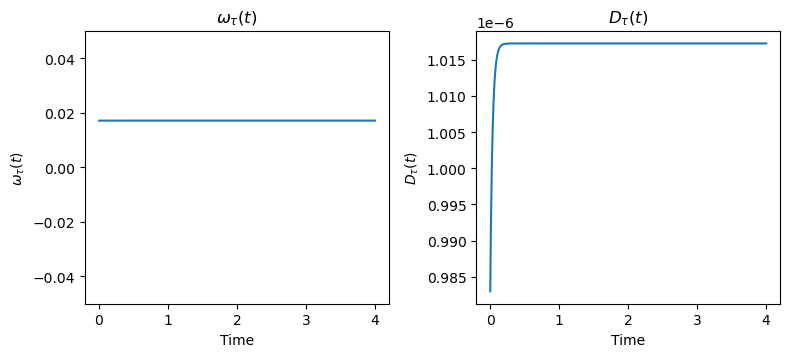

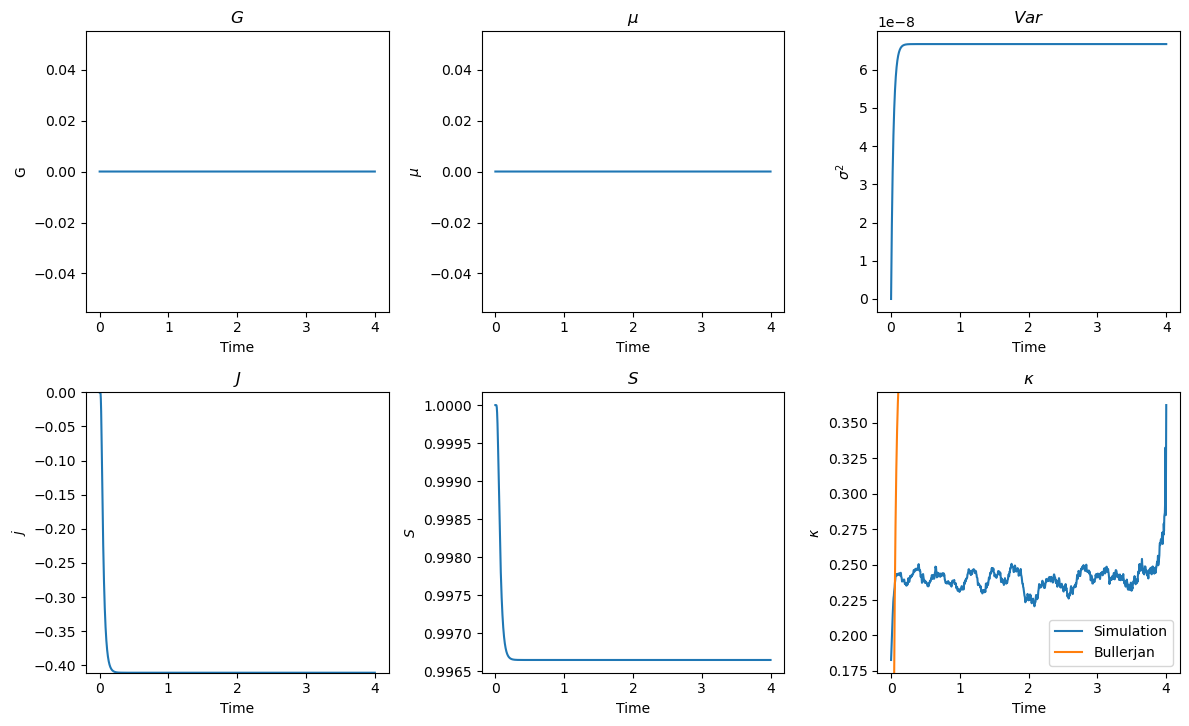

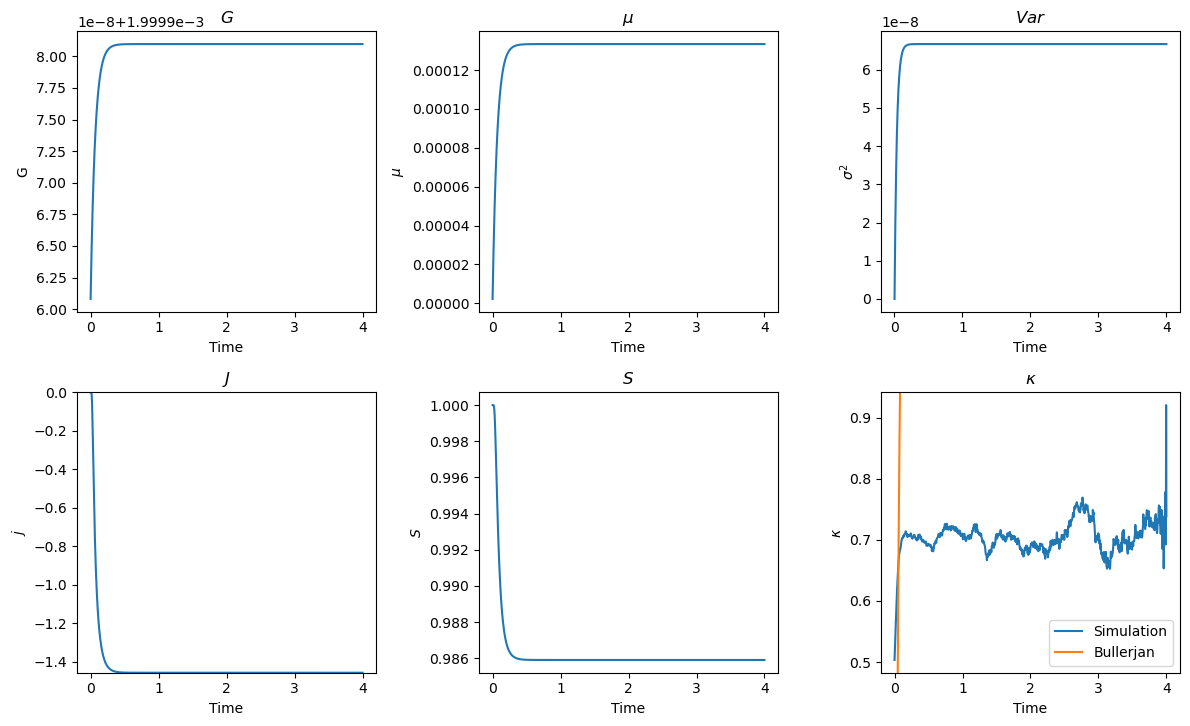

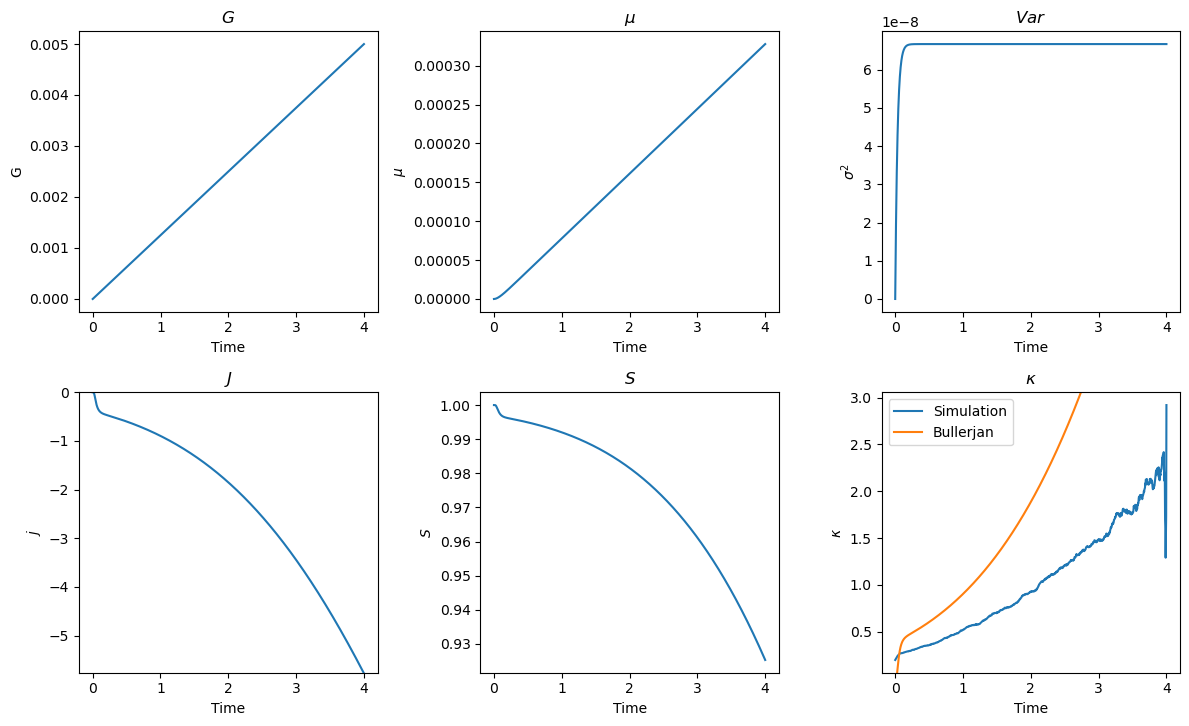

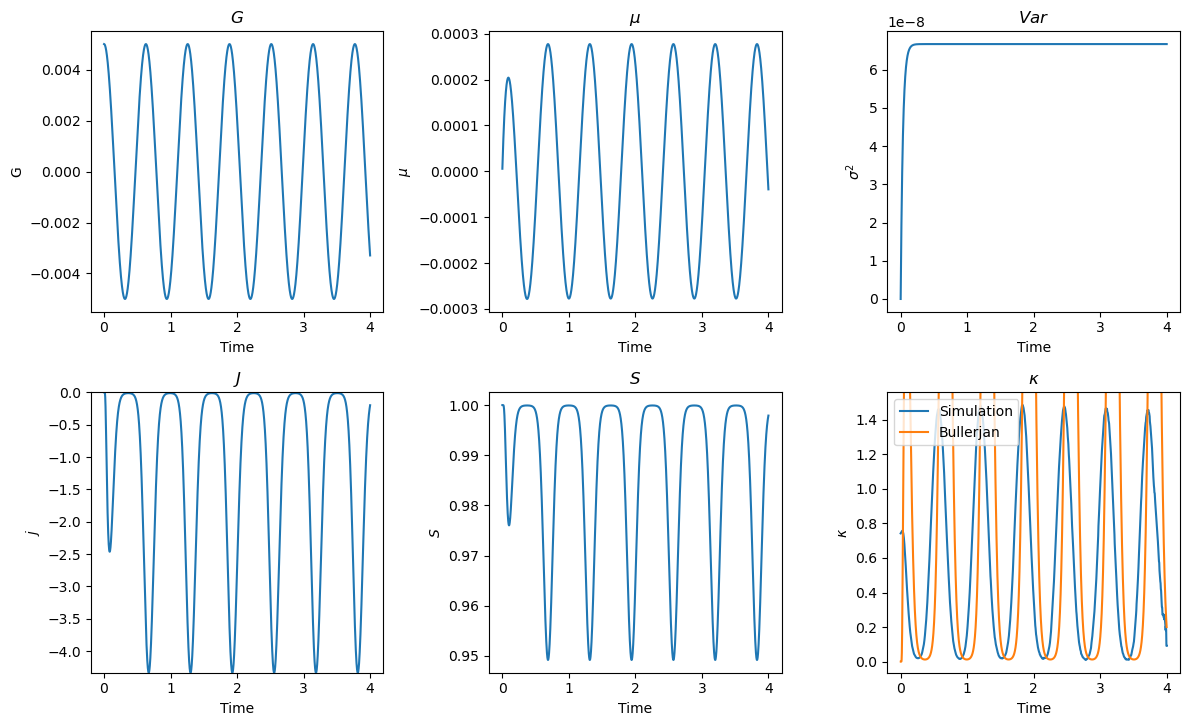

In [13]:


ts_all = np.linspace(0, max_t, 6999)
ts = ts_all[::2]
ts_ = ts_all[1::2]


if tau > 0:
    max_p = int(max_t / tau) + 1
    l_data_all = my_fpc.l(k, tau, ts_all, max_p=max_p)
else:
    l_data_all = np.exp(-k*ts_all)
l_data = l_data_all[::2]
l_data_ = l_data_all[1::2]

w = my_fpc.get_w(l_data, l_data_)
D_t_raw = my_fpc.get_D(l_data, l_data_, ts, max_t,D)
print(D_t_raw)
D_t =  D#np.mean(D_t_raw) #D_t_raw

fig, axs = plt.subplots(1,2, figsize=(8, 4))
axs[0].plot(ts_,w)
axs[0].set_ylim(-0.05,0.05)
axs[0].set_title(r"$\omega_\tau(t)$")
axs[0].set_xlabel("Time")
axs[0].set_ylabel(r"$\omega_\tau(t)$")


axs[1].plot(ts_,D_t_raw)
#axs[1].set_ylim(-1e-7,1e-7)
axs[1].set_title(r"$D_\tau(t)$")
axs[1].set_xlabel("Time")
axs[1].set_ylabel(r"$D_\tau(t)$")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if save_run:
    plt.savefig(pic_path/f'omega_diff.pdf')

for prot in sim_res:
    my_F = np.vectorize(forces[prot])  #lambda i: 0 
    F_data = my_F(ts)
    F_data_ = my_F(ts_)
    G = my_fpc.get_G(l_data,l_data_,ts, F_data, max_t)

    mu = my_fpc.get_M(l_data_,F_data_, ts_, max_t)

    var = my_fpc.get_v_n(l_data_, ts_, max_t, s = s)
    
    d_prefactor = 1 # Bullerjan 2, in approx 4

    j = (w*b-G-d_prefactor*D_t*(b-mu)/var) * 1 / np.sqrt(2*np.pi*var) * np.exp(-(b-mu)**2/(2*var))

    S = 1/2*(1+erf( (b-mu)/np.sqrt(2*var)))


    fig, axs = plt.subplots(2,3, figsize=(12, 8))
    axs[0,0].plot(ts_,G)
    axs[0,0].set_title(r"$G$")
    #axs[0,0].set_ylim(np.sort(G)[11], np.sort(G)[-11])
    axs[0,0].set_xlabel("Time")
    axs[0,0].set_ylabel("G")

    axs[0,1].plot(ts_,mu)
    axs[0,1].set_title(r"$\mu$")
    axs[0,1].set_xlabel("Time")
    axs[0,1].set_ylabel("$\mu$")

    axs[0,2].plot(ts_,var)
    axs[0,2].set_title(r"$Var$")
    axs[0,2].set_xlabel(r"Time")
    axs[0,2].set_ylabel(r"$\sigma^2$")

    #axs[1,2].plot(ts_,(1-S))
    #axs[1,2].set_title(r"$(1-S)$")
    #axs[1,2].plot(time_ramp, sim_res[prot])

    axs[1,0].plot(ts_,j)
    axs[1,0].set_ylim(np.sort(j)[4], np.sort(j)[-4])
    axs[1,0].set_title(r"$J$")
    axs[1,0].set_xlabel(r"Time")
    axs[1,0].set_ylabel(r"$j$")

    axs[1,1].plot(ts_,S)
    axs[1,1].set_title(r"$S$")
    axs[1,1].set_xlabel(r"Time")
    axs[1,1].set_ylabel(r"$S$")
    
    axs[1,2].plot(time_ramp, sim_res[prot], label='Simulation') 
    axs[1,2].set_ylim(*axs[1,2].set_ylim())
    axs[1,2].plot(ts_, -j/S, label='Bullerjan')
    # axs[1,2].set_ylim(np.sort(-j/S)[4], np.sort(-j/S)[-4])
    axs[1,2].set_title(r"$\kappa$")
    axs[1,2].legend()
    axs[1,2].set_xlabel(r"Time")
    axs[1,2].set_ylabel(r"$\kappa$")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_run:
        plt.savefig(pic_path/f'escape_rate_{prot}.pdf')

In [14]:
k,tau

(15, 0)

In [15]:
D, D_t

(1e-06, 1e-06)

(-8e-06, 8e-06)

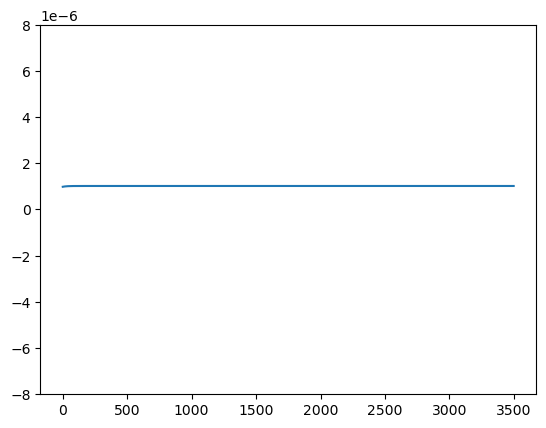

In [16]:
plt.plot(D_t_raw)
np.mean(D_t)
plt.ylim(-8e-6,8e-6)

In [17]:
tau

0